In [1]:
import pandas as pd
import numpy as np
from bq_helper import BigQueryHelper
from blockchain import blockexplorer
from blockchain import util
import time
from tqdm import tqdm
from collections import Counter
import igraph.test

In [9]:
from google.cloud import bigquery

In [8]:
query = """
SELECT
 count(`hash`)
FROM
  `bigquery-public-data.crypto_bitcoin.blocks` blocks
"""

In [11]:
client = bigquery.Client()
q_job = client.query(query)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))

In [2]:
util.TIMEOUT = 15

In [3]:
# unit in satoshi
address = blockexplorer.get_address('3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB')
address2 = blockexplorer.get_address('3EXxYoB61g13UsH1K678G5zeEE8W3XJ2p3')
address3 = blockexplorer.get_address('1NqdBaU9WCvmjGQ1omPx6NHGJYzQo9udd6')
print(address.total_received)
print(address.total_sent)
print(address.final_balance)
print(address.n_tx)
print(address.transactions[0].hash)

655000000000
654990000000
10000000
43
c7ae6fb55b5919bf8239555a11f0309527bac4f18bdc5b9f98fbcd7bf7e83342


idea: use bfs to expand adr to explore. 

for simplicity, neglect amount of transfer for now

for transacitons going out of Target Address, not so interested right now

problem: how to distinguish incoming or outgoing tx?

timeout: The read operation timed out
possible solution: request API key?

before: want to search by distance/radius. now: search by number of nodes to visit

neo4j: transaction/address as vertex. inputs. outputs. 

In [18]:
tx = address.transactions[0]
print(tx.inputs[2].address)
print (addr_queue[0])

3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB


In [4]:
address = '3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB' # tyr with 1 with fewer txs
tx_queue = []
addr_queue = []
addr_queue.append(address)
addr_dict = dict() # key:str address, value: number of visits
max_iter = 1000
for i in tqdm(range(max_iter)):
    #print ("iteration :" + str(i))
    if len(addr_queue) == 0:
        print ("max_iter not reached. All possible addresses explored.")
        break;
    address = addr_queue.pop(0)
     # this process is slow
    if address not in addr_dict:
        addr = blockexplorer.get_address(address)
        tx_queue.extend(addr.transactions)
        addr_dict[address] = 1
        #print (address)
    else:
        addr_dict[address] += 1
    while len(tx_queue) > 0:
        tx = tx_queue.pop(0)
        isReceiver = False;
        # check if this addr is receiving money
        for out in tx.outputs:
            if addr.address == out.address:
                isReceiver = True;
                break;
        if isReceiver:
            for inp in tx.inputs:
                addr_queue.append(inp.address)

100%|██████████████| 1000/1000 [10:14<00:00,  1.63it/s]


In [5]:
print (len(addr_queue))
print (len(tx_queue))
print (len(addr_dict))

21080
0
415


In [6]:
scores = Counter(addr_dict)
print (scores.most_common(5))

[('1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s', 285), ('1BUYBTC1oYQtAjktSRZUtjkeBJ15ABc5bb', 86), ('1Kr6QSydW9bFQG1mXiPNNu6WpJGmUa9i1g', 68), ('1BestMixVhna91MkP7pKRtjej3bFq6Ze46', 44), ('1AK4LYE6PYwBmSYHQX3v2UsXXHTvCAsJeK', 40)]


Explanation: After use BFS to visit first 1000 (with duplicates)addresses, there are in fact 415 unique nodes. And the nodes to be explored reach 21080. Total time taken locally is 10min. 

With this much exploration: top 5 addresses are listed above, the number associated is the number of transactions related to TA. '1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s' is an interesting one with 285 transacitons. (Maybe should count total number of transacitons related to TA, but this metric can be changed into amount of BTC later)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
## Small dataset with networkx
G=nx.DiGraph()
G.add_node(1)
G.add_nodes_from([2,3])
G.add_edges_from([(1,2),(1,3)])

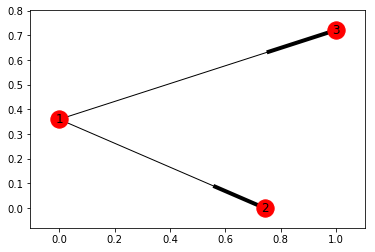

In [11]:
nx.draw_networkx(G)
plt.show()